In [1]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import load_image
from imutils.paths import list_images
from pprint import pprint

from scipy.spatial.distance import euclidean

In [2]:
json_dict = {
    # 'flickr': './json_data/FLICKR.json',
    'splunk': './json_data/Splunk.json',
}

datasets = {
    # 'flickr': '/media/wd_black/datasets/dataset_pad',
    'splunk': '/media/wd_black/datasets/dataset_pad',
}

dst_dataset = '../data/02_intermediate/splunk-periocular'

In [3]:
for json_key in json_dict.keys():
    js = json.load(open(json_dict[json_key]))
    print(f'Length of dataset {json_key}: {len(js)}\n')
    
    attacks = []
    bonafide = []
    
    for elem in js:
        # pprint(elem)
        split = elem.get('image_dir').split(os.sep)
        if split[1] == 'attack':
            attacks.append(elem)
        else:
            bonafide.append(elem)
    
    print(f'bonafide len: {len(bonafide)}')
    print(f'attack len: {len(attacks)}\n\n')
    
    # break

Length of dataset splunk: 24930

bonafide len: 5997
attack len: 18933




In [4]:
# agrupar imagenes y metadata en bonafide vs ataque y contar cuantas imagenes pasaron vs cuantas deberian ser
# generar array con indices de imagenes por cada dataset y guardarlo

In [5]:
len(bonafide), len(attacks)

(5997, 18933)

In [6]:
elem.get('mtcnn-inference')['box']

[130, 360, 550, 730]

ye


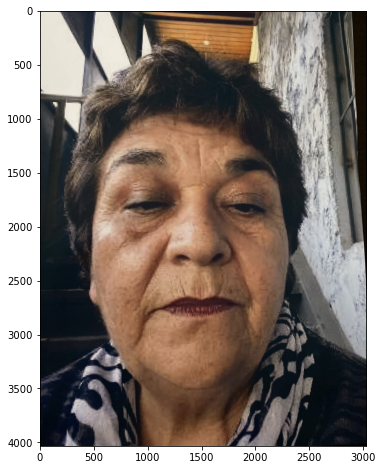

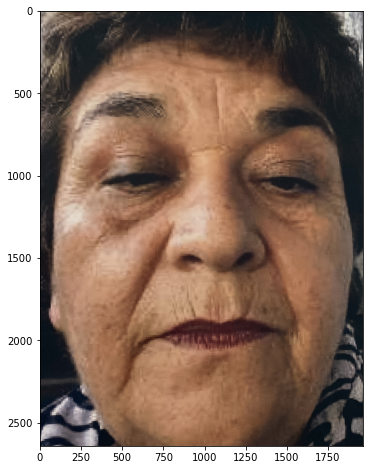

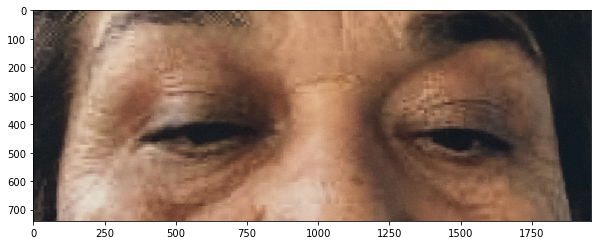

ye


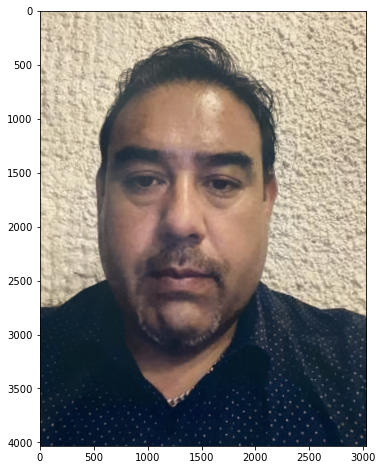

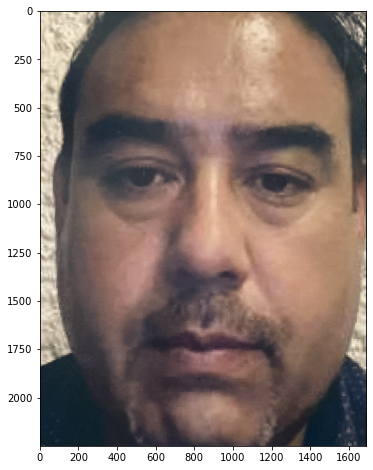

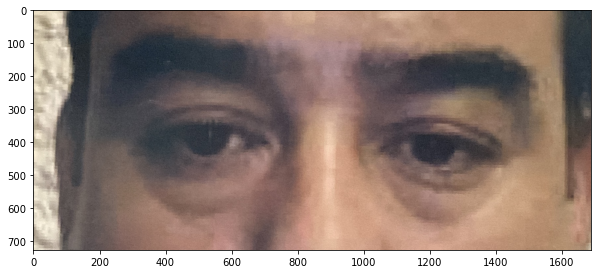

In [7]:
# calcular area, ancho y largo de zonas perioculares

i = 0

for json_key in json_dict:
    js = json.load(open(json_dict[json_key]))
    
    for elem in js:
        imdir = elem.get('image_dir')
        imdir = os.path.join(datasets[json_key], imdir)
        # print(imdir)
        
        if os.path.isfile(imdir):
            print('ye')
            image = load_image(imdir)
            
            # get bbox from elem
            bbox = elem.get('mtcnn-inference').get('box')
            
            
            
            
            nose = elem.get('mtcnn-inference').get('keypoints').get('nose')
            left_eye, right_eye = elem.get('mtcnn-inference').get('keypoints')['left_eye'], elem.get('mtcnn-inference').get('keypoints')['right_eye']
            dst1, dst2 = euclidean(left_eye, nose), euclidean(right_eye, nose)
            mean_dst = np.mean([dst1, dst2]).astype(np.uint16)

            periocular = image.copy()

            pt1 = (bbox[0], left_eye[1]-int(mean_dst*0.6))
            pt2 = (bbox[0]+bbox[2], right_eye[1]+int(mean_dst*0.6))


            periocular = periocular[ pt1[1]:pt2[1], pt1[0]:pt2[0], ... ] # use the generated points to crop the ROI
            # face + distance
            # periocular = cv2.rectangle(periocular, pt1, pt2, color=[255, 0, 0], thickness=50)
            
            # get xy
            face = image[ bbox[1]: bbox[1] + bbox[3], bbox[0]: bbox[0] + bbox[2] ]
            # crop face
            

            
            plt.figure(figsize=(10, 8))
            plt.imshow(image)
            plt.show()
            
            plt.figure(figsize=(10, 8))
            plt.imshow(face)
            plt.show()
            
            plt.figure(figsize=(10, 8))
            plt.imshow(periocular)
            plt.show()
            
            
            i += 1
            if i == 2: break
        else:
            continue
        
    break

In [8]:
# 1. agrupar imagenes en bonafide vs atk1 vs atk2 vs atk_n

In [9]:
bonafide_list = [] # [ (imdir, dict_info) ]
attack_list = []


for json_key in json_dict:
    # load json
    js = json.load(open(json_dict[json_key]))
    # get name from json file
    js_basename = os.path.basename(json_dict[json_key])
    db_name = js_basename.split('.')[0] # drop extension
    
    for elem in js:
        imdir = elem.get('image_dir')
        imdir = os.path.join(datasets[json_key], imdir)
        
        # split by db name and get type of attack
        if 'bonafide' in imdir.split(os.sep):
            bonafide_list.append((imdir, elem))
        else:
            attack_list.append((imdir, elem))

In [10]:
# escenario 1. bonafide vs binary_attack

In [11]:
# bonafide processing

os.makedirs(os.path.join(dst_dataset, 'bonafide'), exist_ok=True)

# iterate over lists, crop and save images as its class
for imdir, info in tqdm(bonafide_list, desc='processing bonafide images'):
    # load and crop image
    image = load_image(imdir)
    bbox = info.get('mtcnn-inference').get('box')
    # face = image[ bbox[1]: bbox[1] + bbox[3], bbox[0]: bbox[0] + bbox[2] ] # crop only face
    
    nose = info.get('mtcnn-inference').get('keypoints').get('nose')
    left_eye, right_eye = info.get('mtcnn-inference').get('keypoints')['left_eye'], info.get('mtcnn-inference').get('keypoints')['right_eye']
    dst1, dst2 = euclidean(left_eye, nose), euclidean(right_eye, nose)
    mean_dst = np.mean([dst1, dst2]).astype(np.uint16)
    pt1 = (bbox[0], left_eye[1]-int(mean_dst*0.6))
    pt2 = (bbox[0]+bbox[2], right_eye[1]+int(mean_dst*0.6))
    
    
    periocular = image[ pt1[1]:pt2[1], pt1[0]:pt2[0], ... ] # custom bbox
    face = periocular
    
    # retrieve subfolders info
    name_info = imdir.split('bonafide')[-1][1:]
    name_info_dirname = os.path.dirname(name_info)
    os.makedirs(os.path.join(dst_dataset, 'bonafide', name_info_dirname), exist_ok=True)
    
    face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(dst_dataset, 'bonafide', name_info), face)
    
    # plt.imshow(face)

processing bonafide images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5997/5997 [07:42<00:00, 12.96it/s]


In [ ]:
# binary attack processing

os.makedirs(os.path.join(dst_dataset, 'attack'), exist_ok=True)

# iterate over lists, crop and save images as its class
for imdir, info in tqdm(attack_list, desc='processing attack images'):
    # load and crop image
    image = load_image(imdir)
    bbox = info.get('mtcnn-inference').get('box')
    # face = image[ bbox[1]: bbox[1] + bbox[3], bbox[0]: bbox[0] + bbox[2] ] # crop only face
    
    nose = info.get('mtcnn-inference').get('keypoints').get('nose')
    left_eye, right_eye = info.get('mtcnn-inference').get('keypoints')['left_eye'], info.get('mtcnn-inference').get('keypoints')['right_eye']
    dst1, dst2 = euclidean(left_eye, nose), euclidean(right_eye, nose)
    mean_dst = np.mean([dst1, dst2]).astype(np.uint16)
    pt1 = (bbox[0], left_eye[1]-int(mean_dst*0.6))
    pt2 = (bbox[0]+bbox[2], right_eye[1]+int(mean_dst*0.6))
    
    
    periocular = image[ pt1[1]:pt2[1], pt1[0]:pt2[0], ... ] # custom bbox
    face = periocular
    
    # retrieve subfolders info
    name_info = imdir.split('attack')[-1][1:]
    name_info_dirname = os.path.dirname(name_info)
    os.makedirs(os.path.join(dst_dataset, 'attack', name_info_dirname), exist_ok=True)
    
    face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(dst_dataset, 'attack', name_info), face)
    
    # plt.imshow(face)

processing attack images:   1%|██                                                                                                                                            | 272/18933 [01:44<2:30:23,  2.07it/s]

In [ ]:
# make train file with models to train

In [ ]:
# escenario 2. bonafide vs atk1 vs atk2 vs atk_n

In [ ]:
# TODO:

# 1. agrupar imagenes en bonafide vs atk1 vs atk2 vs atk_n
# 1.1. ojala bonafide sea una carpeta con carpetas y los impostores sean tambien una carpeta con carpetas

# 2. respetar metodologia de entrenamiento
# primero caras -> recortarlas
# despues periocular